# **Test DP integration**

Simple Jupyter notebook testing an adaptation of the Villa Martín/Buendía (VMB)
implementation of the Dornic et al (2005) method of integrating DP/APT-type
Langevin equations using an operator-splitting method. Access to the heavily 
refactored VMB C++ code is provided via a pybind11 wrapper.

See the repo README for references.

<hr>

## Preliminaries

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from numpy.typing import NDArray
# import os, sys
# sys.path.insert(0, os.path.abspath('../'))
import dplvn
import initialize

<hr>

## Package `dplvn` info

In [2]:
help(dplvn)

Help on module dplvn:

NAME
    dplvn - 'Dornic' operator-splitting method of integrating DP-type Langevin equations

FUNCTIONS
    dp(...) method of pybind11_builtins.pybind11_detail_function_record_v1_system_libcpp_abi1 instance
        dp(linear: typing.SupportsFloat = 1.0, quadratic: typing.SupportsFloat = 2.0, diffusion: typing.SupportsFloat = 0.1, noise: typing.SupportsFloat = 1.0, n_cells: typing.SupportsInt = 4096, t_max: typing.SupportsFloat = 100.0, dx: typing.SupportsFloat = 0.5, dt: typing.SupportsFloat = 0.01, random_seed: typing.SupportsInt = 1) -> numpy.typing.NDArray[numpy.float64]

        Demo application of the Dornic method

FILE
    /Users/cps/miniconda3/envs/dplvn3p12/lib/python3.12/site-packages/dplvn.cpython-312-darwin.so




In [3]:
help(dplvn.dp)

Help on built-in function dp in module dplvn:

dp(...) method of pybind11_builtins.pybind11_detail_function_record_v1_system_libcpp_abi1 instance
    dp(linear: typing.SupportsFloat = 1.0, quadratic: typing.SupportsFloat = 2.0, diffusion: typing.SupportsFloat = 0.1, noise: typing.SupportsFloat = 1.0, n_cells: typing.SupportsInt = 4096, t_max: typing.SupportsFloat = 100.0, dx: typing.SupportsFloat = 0.5, dt: typing.SupportsFloat = 0.01, random_seed: typing.SupportsInt = 1) -> numpy.typing.NDArray[numpy.float64]

    Demo application of the Dornic method



<hr>

## Demo

Perform demo integration of a DP Langevin on a $64 \times 64$ grid 
(4096 cells) with simple choices of parameters.

In [4]:
result: NDArray = dplvn.dp(
    # n_cells=64, #4096 
    linear=1.0, quadratic=2.0, diffusion=0.1, noise=1.0, 
    # t_max=100.0, dx=0.5, dt=0.01
)

linear: 1
quadratic: 2
diffusion: 0.1
noise: 1
n_cells: 4096
t_max: 100
dx: 0.5
dt: 0.01
random_seed: 1
In Dornic_DP class instance
Total number of epochs: 10001


Simulation results are returned as a `numpy` array with integration time steps
("epochs") in the first column and grid-mean density ("mean_densities") in the
second column. 

In [5]:
type(result), result.shape

(numpy.ndarray, (10001, 2))

In [6]:
epochs: NDArray = result[:, 0]
mean_densities: NDArray = result[:, 1]
epochs[-10:], mean_densities[-10:]

(array([ 99.91,  99.92,  99.93,  99.94,  99.95,  99.96,  99.97,  99.98,
         99.99, 100.  ]),
 array([0.20601195, 0.20461128, 0.20483021, 0.20510216, 0.20479863,
        0.20515703, 0.20619342, 0.20591632, 0.20805732, 0.20747521]))

<hr>

## Plot results

Plot the time-series of grid-averaged density field.

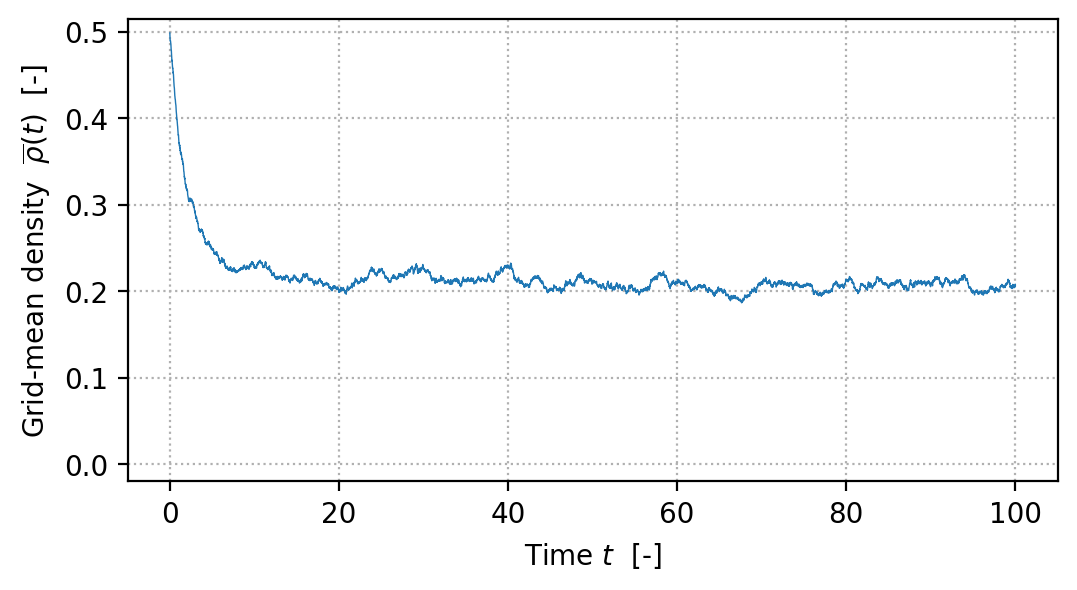

In [7]:
fig = plt.figure(figsize=(6,3))
plt.plot(epochs, mean_densities, "-", lw=0.5,)
plt.xlabel(r"Time $t$  [-]")
plt.ylabel(r"Grid-mean density  $\overline{\rho}(t)$  [-]")
plt.ylim(-0.02, None)
plt.grid(ls=":")

In [8]:
fig.savefig(
    "meandensity_time.png",
    bbox_inches="tight",
    pad_inches=0.05,
    dpi=150,
    format="PNG",
)